# **LSTM-based Semantic Analysis** 

This project aims to develop the model that detects emotions from the text using PyTorch library. 

## **Model**

In this notebook, we introduce you to the model based on LSTM, PyTorch and GloVe and that takes word sequences as an input and feed into LSTM to predict the emotion based on text. Prior to that we use pre-trained Glove word embeddings to represent the word.
 

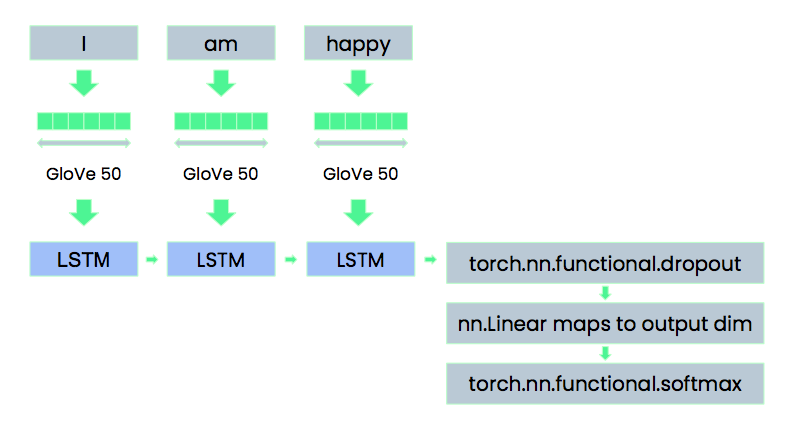

# **Dataset**

We utilize the dataset containing 132 labeled sentences. The labels are presented in the form of itegers from [0,4] corresponding to 5 different emotions.

The dataset is split into the training and test set, containing 132 and 56 instances respectively. Each sentence contains up to 10 words.

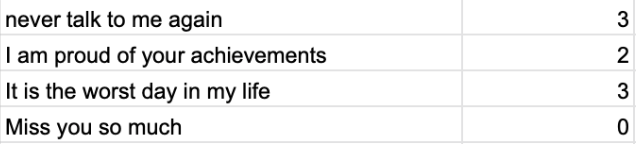

## **Code**

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# READS GLOVE AND OUTPUTS words_to_index = INDEX OF THE WORD; index_to_words = WORD; word_to_vec_map = VECTOR OF THE WORD

def read_vectors(glove_f):
    with open(glove_f, 'r') as f:
        words = set()
        word_to_vec = {} 
        
        for line in f:
            line = line.strip().split()
            current = line[0]
            words.add(current)
            word_to_vec[current] = np.array(line[1:], dtype=np.float64)
        
        j = 1
        words_to_index = {}
        index_to_words = {}

        for word in sorted(words):
            words_to_index[word] = j
            index_to_words[j] = word
            j += 1

    return words_to_index, index_to_words, word_to_vec

# CONVERTS LABELS TO ONE HOT CODE 5
def convert(y, c):
    y = np.eye(c)[y.reshape(-1)]
    return y

# READS CSV AND OUTPUT X AND Y
def csv_reader(filename):

    with open (filename) as csvData:
        df = pd.read_csv(csvData, header=None)
        
    x = np.asarray(df[0])
    y = np.asarray(df[1], dtype=int)

    return x, y

In [16]:
xtrain, ytrain = csv_reader('/content/drive/My Drive/emotion_detection/datasets/train.csv')
xtest, ytest = csv_reader('/content/drive/My Drive/emotion_detection/datasets/test.csv')

In [17]:
C = 5
Y_oh_train = convert(ytrain, C)
Y_oh_test = convert(ytest, C)

In [18]:
word_to_index, index_to_word, word_to_vec = read_vectors('/content/drive/MyDrive/emotion_detection/datasets/glove.6B.50d.txt')

In [19]:
# CONVERTS AN ARRAY OF STR TO ARRAY OF INDICES
def sentence_to_index(x, word_to_index, max_len):    
    num_train = x.shape[0]  # number of training examples
    
    # Initialize x_idx as a numpy matrix of zeros and the correct shape
    x_idx = np.zeros((num_train,max_len))
    
    for a in range(num_train):  
        
        # Convert the i-th sentence in lower case and split into a list of words
        sentence = x[a].lower().split()
        
        b = 0
        
        for word in sentence:
            x_idx[a, b] = word_to_index[word]
            b += 1
    
    return x_idx

In [20]:
x1 = np.array(["Very funny", "I adore you", "this looks so delicious"]) 
x1_idx = sentence_to_index(x1, word_to_index, max_len = 5)
print("x1 =", x1)
print("x1 index =", x1_idx)

x1 = ['Very funny' 'I adore you' 'this looks so delicious']
x1 index = [[377946. 155345.      0.      0.      0.]
 [185457.  46797. 394475.      0.      0.]
 [358160. 225650. 336114. 120044.      0.]]


# **Define the Network using Pretrained Embedding Layer using GloVe Word Embeddings**

In [25]:
class NN(nn.Module):
  def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, output_dim, batch_size):
      super(NN, self).__init__()

      self.batch_size = batch_size

      self.hidden_dim = hidden_dim

      self.word_embeddings = embedding

      # The LSTM takes word embeddings as inputs, and outputs hidden states with dimensionality hidden_dim.
      
      self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=2,
                          dropout = 0.5,
                          batch_first = True)

      # The linear layer that maps from hidden state space to output space
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, sentence):

      sentence = sentence.to(device)

      embeds = self.word_embeddings(sentence)

      h0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      c0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      
      lstm_out, h = self.lstm(embeds, (h0, c0)) # get info from last timestep only
      
      lstm_out = lstm_out[:, -1, :]


      # Dropout
      lstm_out = F.dropout(lstm_out, 0.5)

      # Linear layer
      fc_out = self.fc(lstm_out)
      
      out = fc_out
      out = F.softmax(out, dim=1)

      return out
  

## **Create Glove Embedding Layer**

In [22]:
# CREATES AN ARRAY WITH ALL GLOVE VECTORS WITH SHAPE (1M, 50) AND CONVERTS IT TO EMBEDDING LAYER
# OUTPUTS embed = EMBEDDING LAYER; num_embeddings = NUMBER OF ALL WORDS IN THE GLOVE (1M); embedding_dim = DIMENSIONS (1M, 50)

def pretrained_layer(word_to_vec, word_to_index, non_train=True):
    embeddings_number = len(word_to_index) + 1                   
    embedding_dimension = word_to_vec["cucumber"].shape[0]  #  dimensionality of GloVe word vectors (= 50)

    weights= np.zeros((embeddings_number, embedding_dimension))
    for word, i in word_to_index.items():
        weights[i, :] = word_to_vec[word]

    fit = nn.Embedding.from_pretrained(torch.from_numpy(weights).type(torch.FloatTensor), freeze=non_train)

    return fit, embeddings_number, embedding_dimension

# **Training**

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #select the gpu if it is available, if not trains on cpu

def train(model, load_train, criterion, optimizer, num_epochs=10):
    
    model.to(device)
    run_loss = 0
    
    train_losses, test_losses, accuracy = [], [], []
    for epoch in range(num_epochs):

        run_loss = 0
        
        model.train()
        
        for sentences, labels in load_train:

            sentences, labels = sentences.to(device), labels.to(device)

            optimizer.zero_grad()
            pred = model.forward(sentences)  # makes a prediction
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() # log progress
        
        
        else:

          model.eval()

          test_loss = 0
          acc = 0
          
          with torch.no_grad():
              for sentences, labels in load_test:
                  sentences, labels = sentences.to(device), labels.to(device)
                  log_ps = model(sentences)
                  test_loss += criterion(log_ps, labels)
                  
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  acc += torch.mean(equals.type(torch.FloatTensor))
                  
          train_losses.append(run_loss/len(load_train))
          test_losses.append(test_loss/len(load_test))
          accuracy.append(acc / len(load_test) * 100)

          print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
                "Training Loss: {:.3f}.. ".format(run_loss/len(load_train)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(load_test)),
                "Test Accuracy: {:.3f}".format(acc/len(load_test)))
    return train_losses, test_losses, accuracy    


In [28]:
import torch.utils.data

maxLen = len(max(xtrain, key=len).split())

x_train_idx = sentence_to_index(xtrain, word_to_index, maxLen)

y_train_converted = convert(ytrain, C)

x_test_idx = sentence_to_index(xtest, word_to_index, maxLen)
y_test_converted = convert(ytest, C)

embedding, vocab_size, embedding_dim = pretrained_layer(word_to_vec, word_to_index, non_train=True)

hidden_dim=128
output_size=5
batch_size = 32

model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
num_epochs = 50
train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train_idx).type(torch.LongTensor), torch.tensor(ytrain).type(torch.LongTensor))
load_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test_idx).type(torch.LongTensor), torch.tensor(ytest).type(torch.LongTensor))
load_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses, test_losses, accuracy = train(model, load_train, criterion, optimizer, num_epochs)

Epoch: 1/50..  Training Loss: 1.601..  Test Loss: 1.584..  Test Accuracy: 0.349
Epoch: 2/50..  Training Loss: 1.581..  Test Loss: 1.548..  Test Accuracy: 0.292
Epoch: 3/50..  Training Loss: 1.569..  Test Loss: 1.554..  Test Accuracy: 0.224
Epoch: 4/50..  Training Loss: 1.556..  Test Loss: 1.529..  Test Accuracy: 0.438
Epoch: 5/50..  Training Loss: 1.548..  Test Loss: 1.520..  Test Accuracy: 0.333
Epoch: 6/50..  Training Loss: 1.498..  Test Loss: 1.507..  Test Accuracy: 0.375
Epoch: 7/50..  Training Loss: 1.517..  Test Loss: 1.506..  Test Accuracy: 0.365
Epoch: 8/50..  Training Loss: 1.487..  Test Loss: 1.511..  Test Accuracy: 0.375
Epoch: 9/50..  Training Loss: 1.434..  Test Loss: 1.473..  Test Accuracy: 0.411
Epoch: 10/50..  Training Loss: 1.394..  Test Loss: 1.460..  Test Accuracy: 0.411
Epoch: 11/50..  Training Loss: 1.363..  Test Loss: 1.410..  Test Accuracy: 0.505
Epoch: 12/50..  Training Loss: 1.340..  Test Loss: 1.426..  Test Accuracy: 0.505
Epoch: 13/50..  Training Loss: 1.325.

# **Plot results on a graph**

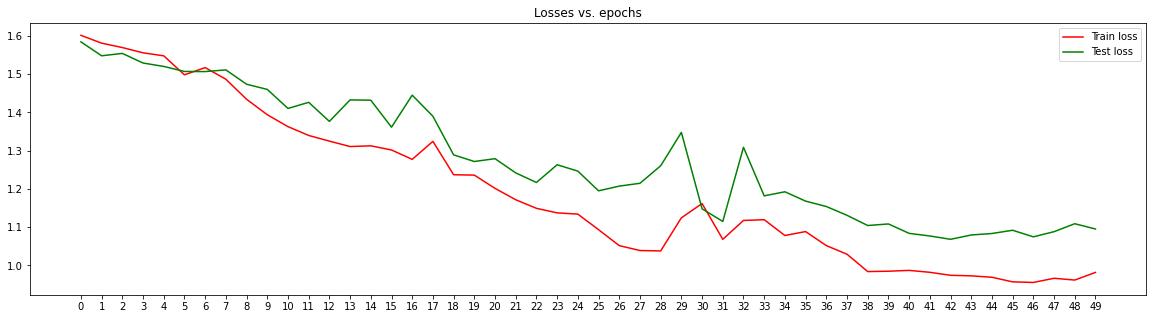

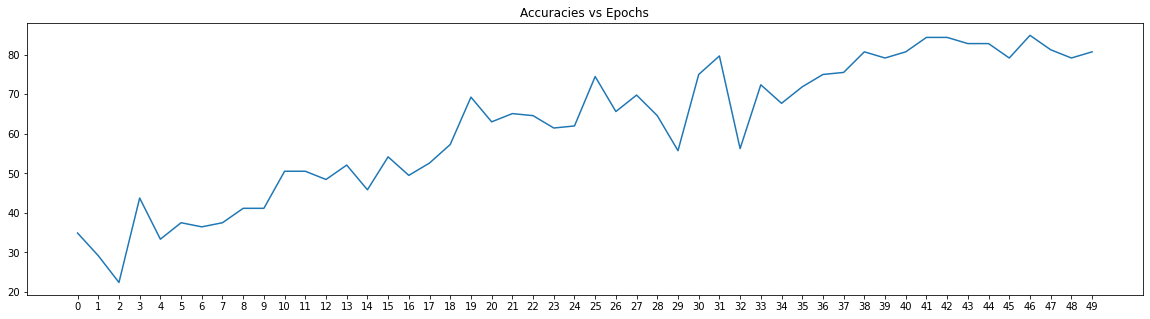

In [39]:
#plot losses vs. epoch graph
plt.figure(figsize=(20, 5))
plt.plot(train_losses, c='r', label='Train loss')
plt.plot(test_losses, c='g', label='Test loss')
plt.xticks(np.arange(0, num_epochs))
plt.title('Losses vs. epochs')
plt.legend(loc='upper right')
plt.show()

#plot accuracy vs. epochs graph
plt.figure(figsize=(20, 5))
plt.plot(accuracy)
plt.xticks(np.arange(0, num_epochs))
plt.title('Accuracies vs Epochs')
plt.show()

# **Evaluate the accuracy on a test set**

In [30]:
loss_test = 0
accuracy_test = 0
model.eval()
with torch.no_grad():
    for sentences, labels in load_test:
        sentences, labels = sentences.to(device), labels.to(device)
        m = model(sentences)
        loss_test += criterion(m, labels).item()

        # Compute the accuracy
        highest_p, highest_class = m.topk(1, dim=1)
        equals = highest_class == labels.view(*highest_class.shape)
        accuracy_test += torch.mean(equals.type(torch.FloatTensor))
model.train()
len_test = len(load_test)
print("The Loss on the test set: {:.3f}. ".format(loss_test/len_test),
      "The Accuracy on the test set: {:.3f}".format(accuracy_test/len_test))
run_loss = 0

The Loss on the test set: 1.095.  The Accuracy on the test set: 0.828


# **Test the model on a random sentence**

In [31]:
def predict(text, print_info = True):
  labels_dict = {
		0 : "Loving",
		1 : "Excited",
		2 : "Happy",
		3 : "Sad",
		4 : "Bored",
	}

  # Converts the input to the model
  x_test = np.array([text])
  x_test_idx = sentence_to_index(x_test, word_to_index, maxLen)
  sentences = torch.tensor(x_test_idx).type(torch.LongTensor)

  # Retrieves the class label
  ps = model(sentences)
  highest_p, highest_class = ps.topk(1, dim=1)
  label = int(highest_class[0][0])

  if print_info:
    print("\nThe Sentence: \t"+ text +'\n Predicted Emotion: \t'+  labels_dict[label])

  return label

In [36]:
# Let's check model's predictions on some random sentences  
print("------------------------------------")
predict("I want to eat")
predict("I love you")
predict("Great")
predict("I want to see the game")
predict("This is the worst day of my life")
print("\n------------------------------------")

------------------------------------

The Sentence: 	I want to eat
 Predicted Emotion: 	Bored

The Sentence: 	I love you
 Predicted Emotion: 	Loving

The Sentence: 	Great
 Predicted Emotion: 	Happy

The Sentence: 	I want to see the game
 Predicted Emotion: 	Excited

The Sentence: 	This is the worst day of my life
 Predicted Emotion: 	Sad

------------------------------------


# **Results**

To conclude, we succesfully created a model that achieves 83% accuracy. We tested it on user inputted sentences and got expected emotion outputs, verifying the validity of our model.

Test Loss: 1.095.. Test Accuracy: 0.828

